In [20]:
#     This program is free software: you can redistribute it and/or modify
#     it under the terms of the GNU General Public License as published by
#     the Free Software Foundation, either version 3 of the License, or
#     (at your option) any later version.
#
#     This program is distributed in the hope that it will be useful,
#     but WITHOUT ANY WARRANTY; without even the implied warranty of
#     MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#     GNU General Public License for more details.
#
#     You should have received a copy of the GNU General Public License
#     along with this program.  If not, see <https://www.gnu.org/licenses/>.

#     Written by Charalambos (Charis) Poullis - www.poullis.org

In [21]:
#Import all necessary libraries
import torch
import torchvision
import numpy as np
#progress bar functionality
import tqdm
#plotting etc
import matplotlib

import matplotlib.pyplot as plt
#random number generator
import random

# There is a weird crash in Python 3.9 causing the kernel to restart when using matplotlib
# To test if you have the same issue uncomment the following command. If it works, then you don't need the subsequent 2 lines (import os, KMP)
#plt.subplot()
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [22]:
#Set the path for the datasets
DATASET_PATH = "../data"

#Download the training dataset: CIFAR10
training_dataset = torchvision.datasets.CIFAR10(root=DATASET_PATH,
                                                train=True,
                                                download=True,
                                                transform=torchvision.transforms.ToTensor())
print('Training dataset:', training_dataset)

#Download the testing dataset: CIFAR10
testing_dataset = torchvision.datasets.CIFAR10(root=DATASET_PATH,
                                               train=False,
                                               download=True,
                                               transform=torchvision.transforms.ToTensor())
print('Testing dataset:', testing_dataset)  

#Create a list with user-friendly names for each label
labels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

Files already downloaded and verified
Training dataset: Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: ToTensor()
Files already downloaded and verified
Testing dataset: Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [23]:
#This function takes a CIFAR dataset and splits it into two numpy arrays containing
#the images and labels, respectively

def splitDataset(dataset):
    #Divide the datasets into images and labels
    x, y = dataset[0]
    
    shape = [(i, *j) for i, j in [(len(dataset), x.shape)]][0]
    images = np.zeros(shape)
    labels = np.zeros((len(dataset), 1))
    
    for i in range(len(dataset)):
        x,y = dataset[i]
        images[i] = x
        labels[i] = y
        
    images = np.reshape(images, (len(dataset), 3, 32, 32))
    labels = np.reshape(labels, (len(dataset), 1))
    return images, labels

In [24]:
#Divide the training datasets into images and labels; this is needed later to randomly index from the arrays
training_images, training_labels = splitDataset(training_dataset)
#Do the same for the testing dataset
testing_images, testing_labels = splitDataset(testing_dataset)   

print(f'Training images: {len(training_images)}, Training labels: {len(training_labels)}')
print(f'Testing images: {len(testing_images)}, Testing labels: {len(testing_labels)}')

Training images: 50000, Training labels: 50000
Testing images: 10000, Testing labels: 10000


In [25]:
#We'll use GPU is available; check if a GPU is available
print(f'GPU devices found: {torch.cuda.device_count()}')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

GPU devices found: 0
Device: cpu


In [26]:
#Define the linear classifier; it has a single layer and performs the linear operation Wx + b
class MyNN (torch.nn.Module):
    def __init__(self, input_channels, number_of_classes):
        super(MyNN, self).__init__()
        
        #Define the input channels for each layer; adjust this list to change the number of layers and sizes
        self.layer_sizes = [input_channels, 20, 10, number_of_classes]
        
        #This list will keep each layer of the model
        self.layers = torch.nn.ModuleList()
        
        for i in range(len(self.layer_sizes)-1):
            in_features = self.layer_sizes[i]
            out_features = self.layer_sizes[i + 1]
            self.layers.append(torch.nn.Linear(in_features=in_features, out_features=out_features))
            self.layers.append(torch.nn.ReLU())
        
        self.layers.append(torch.nn.Softmax(dim=0))
        
        return
    
    def forward(self, batch_size, x):
        result = x.reshape((batch_size, -1))
        for i in range(len(self.layers)):
            result = self.layers[i](result)
        # result = result.reshape((batch_size, -1))
        return result

In [27]:
#Calculate the input channels; check the size of the first image
img, label = training_dataset[0]
image_size = img.shape[0]*img.shape[1]*img.shape[2]

#Create an instance of the model and print; it should display all the layers and their related information; push to the device
NUMBER_OF_CLASSES = 10
model = MyNN(image_size, NUMBER_OF_CLASSES).to(device)
print(model)

MyNN(
  (layers): ModuleList(
    (0): Linear(in_features=3072, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Softmax(dim=0)
  )
)


In [28]:
#SANITY CHECK: Feed forward an image and check for errors
#Push the image to the device
img = img.to(device)
model.forward(1, img)

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], grad_fn=<SoftmaxBackward>)

In [29]:
#TRAINING

#define the hyperparameters
EPOCHS=20
LEARNING_RATE=0.1
BATCH_SIZE = 100

#Create an optimizer and pass the model's parameters
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

#Define a loss function; we'll pick mean squared error since we are reconstructing the original
loss_function = torch.nn.CrossEntropyLoss()

#training image indices
training_dataset_indices = torch.arange(0, len(training_dataset))

#keep track of the losses
losses = list()

#Create a progress bar the size of the number of epochs
status_bar = tqdm.tqdm(range(EPOCHS), ncols=100, desc='loss: -1.0')
for i in status_bar:
    #At each iteration, perform a permutation of the training_dataset_indices; this ensures that we will use all images and avoid duplication
    random_permutation = torch.randperm(training_dataset_indices.size()[0])

    #Get BATCH_SIZE training images at each epoch; because we sample from an array there will be no duplicates
    for b in range(0,training_dataset_indices.size()[0], BATCH_SIZE):
        #Zero out the gradients
        optimizer.zero_grad()

        #Get the indices of the training images in this batch
        batch_indices = random_permutation[b:b+BATCH_SIZE]
        batch_images, batch_labels = training_images[batch_indices], training_labels[batch_indices]
        batch_images = torch.from_numpy(batch_images).float().to(device)

        #Convert the labels into one hot vectors e.g.  2 -> [0,1,0,0,0,0,0,0,0,0]
        batch_labels = batch_labels.squeeze(1)
        batch_labels = torch.from_numpy(batch_labels).long().to(device)

        #Get the predictions
        predictions = model.forward(BATCH_SIZE, batch_images)

        #Calculate the cross entropy loss
        loss = loss_function(predictions, batch_labels)
        
        #add it to the list
        losses.append(loss.item())
        
        #backpropagate
        loss.backward()
        #single gradient descent step
        optimizer.step()
        
    status_bar.set_description(f'loss: {loss.item():.4f}')

print(f'Final loss on training: {loss.item():.4f}')

loss: 2.2756: 100%|█████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.20it/s]

Final loss on training: 2.2756


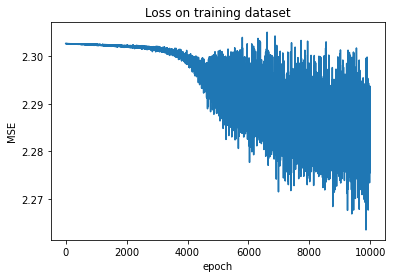

In [30]:
#Plot the loss as a function of epochs
fig, ax = plt.subplots(1,1)
ax.plot(list(range(EPOCHS*int(len(training_dataset)/BATCH_SIZE))), np.array(losses))
ax.set_title('Loss on training dataset')
ax.set_xlabel('epoch')
ax.set_ylabel('MSE')
plt.show()
fig.savefig("linear_classifier_loss.png")